## Discrete-time competitive Beverton-Holt model

\begin{align}
N_{1,t+1}=\dfrac{r_1N_{1,t}}{1+a_{11}N_{1,t}+a_{12}N_{2,t}} \\
N_{2,t+1}=\dfrac{r_2N_{2,t}}{1+a_{22}N_{2,t}+a_{21}N_{1,t}}
\tag{1}
\end{align}

## Packages

In [1]:
import numpy as np # math expressions
import matplotlib.pyplot as plt # plot

from numba import jit

from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('onedork') #grade3

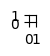

In [2]:
# Dummy plot
fig, ax = plt.subplots(figsize=(0.1, 0.1))
ax.axhline(y=1, color='grey', linestyle='-')
plt.rcParams.update({'font.size': 30})

## Initialization

In [3]:
# Variables for the per capita growth rate
tmax = 2
time = np.linspace(1,tmax,tmax)

y1 = np.zeros(tmax)
y2 = np.zeros(tmax)
#y1_t = np.zeros(tmax)
#y2_t = np.zeros(tmax)
per_capita1 = np.zeros(tmax)
per_capita2 = np.zeros(tmax)

y01, y02 = 5, 5
y1[0], y2[0] = y01, y02 # initial conditions

## Parameters

In [4]:
#C12, C21 > 0: coexistence (always coexistence)
r1=18
r2=13
a11=2.5
a12=0.8
a22=0.7
a21=0.6

C12 = (r1 - 1) / a12 - (1 / a22) * (r2 - 1)
C21 = (r2 - 1) / a21 - (1 / a11) * (r1 - 1)
print('C12='+str(C12)+',C21='+str(C21))

C12=4.107142857142858,C21=13.2


In [5]:
#C12, C21 < 0: extinction of N1 (eqpoint of coexistence is unstable: 235/11, 230/11)
r1=20
r2=18
a11=0.4
a12=0.5
a22=0.2
a21=0.6

C12 = (r1 - 1) / a12 - (1 / a22) * (r2 - 1)
C21 = (r2 - 1) / a21 - (1 / a11) * (r1 - 1)
print('C12='+str(C12)+',C21='+str(C21))

C12=-47.0,C21=-19.166666666666664


In [6]:
#C12C21 < 0: extinction of N1 (always extinction)
r1=16
r2=11
a11=0.7
a12=0.8
a22=0.5
a21=0.2

C12 = (r1 - 1) / a12 - (1 / a22) * (r2 - 1)
C21 = (r2 - 1) / a21 - (1 / a11) * (r1 - 1)
print('C12='+str(C12)+',C21='+str(C21))

C12=-1.25,C21=28.57142857142857


In [7]:
#C12 = C21 = 0: coexistence
r1=15
r2=11
a11=0.7
a12=0.14
a22=0.1
a21=0.5

C12 = (r1 - 1) / a12 - (1 / a22) * (r2 - 1)
C21 = (r2 - 1) / a21 - (1 / a11) * (r1 - 1)
print('C12='+str(C12)+',C21='+str(C21))

C12=-1.4210854715202004e-14,C21=0.0


In [8]:
# Sensitivity Analysis
r1=15
r2=11
a11=0.7
a12=0.14
a22=0.1
a21=0.5

In [18]:
r1=17
r2=15
a11=0.7
a12=0.8
a21=0.1
a22=0.7

print('C12=',(r1 - 1) / a12 - (1 / a22) * (r2 - 1))
print('C21=',(r2 - 1) / a21 - (1 / a11) * (r1 - 1))

C12= 0.0
C21= 117.14285714285714


In [10]:
@jit(nopython=True)
def time_simul(y01,y02,r1,r2,a11,a22,a12,a21):
    tmax = 2
    y1 = np.zeros(tmax)
    y2 = np.zeros(tmax)
    per_cap1 = np.zeros(tmax)
    per_cap2 = np.zeros(tmax)
    y1_relat = np.zeros(tmax)
    y2_relat = np.zeros(tmax)
    y1[0],y2[0] = y01,y02 # initial conditions
    i,stopRun = 0,0
    while stopRun==0: # stops the simulation when the dynamics converges
        per_cap1[i] = r1 / ( 1 + a11 * y1[i] + a12 * y2[i] )
        per_cap2[i] = r2 / ( 1 + a22 * y2[i] + a21 * y1[i] )
        y1[i+1] = y1[i] * per_cap1[i]
        y2[i+1] = y2[i] * per_cap2[i]
        y1_relat[i]=y1[i]/(y1[i]+y2[i])
        y2_relat[i]=y2[i]/(y1[i]+y2[i])
        per_cap1=np.append(per_cap1,per_cap1[i])
        per_cap2=np.append(per_cap2,per_cap2[i])
        y1=np.append(y1,y1[i])
        y2=np.append(y2,y2[i])
        y1_relat=np.append(y1_relat,y1_relat[i])
        y2_relat=np.append(y2_relat,y2_relat[i])
        if np.abs(y1[i+1]-y1[i]) < 1.0e-3 and np.abs(y2[i+1]-y2[i]) < 1.0e-3:
            stopRun=1
        i+=1
        if i>1000:
            break
    return y1,y2

In [11]:
def CBHM(y01, y02, r1, r2, a11, a12, a21, a22):
    y1, y2 = time_simul(y01, y02, r1, r2, a11, a22, a12, a21)
    return y1, y2

In [12]:
y1,y2 = CBHM(y01, y02, r1, r2, a11, a12, a21, a22)

## Relative frequency

In [13]:
y_rel1 = np.zeros(len(y1))
y_rel2 = np.zeros(len(y1))
for i in range(len(y1)):
    y_rel1[i]=y1[i]/(y1[i]+y2[i])
    y_rel2[i]=y2[i]/(y1[i]+y2[i])

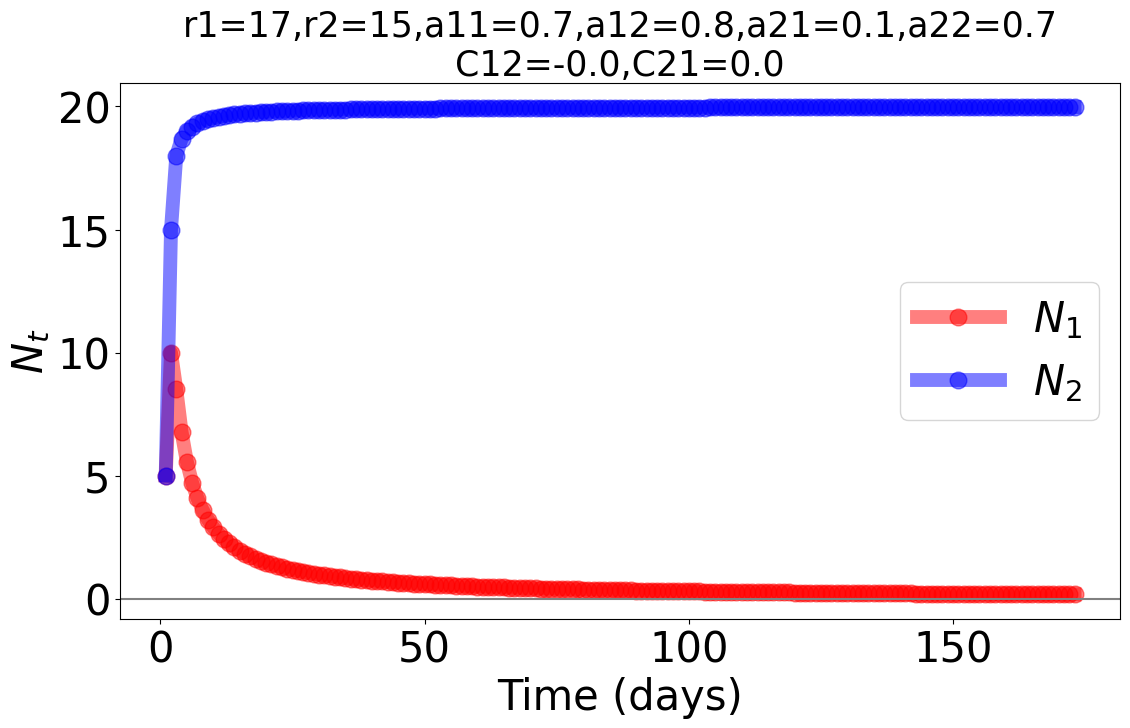

In [14]:
tmax = len(y1)
time = np.linspace(1,tmax,tmax)

fig, (ax) = plt.subplots(1,figsize=(12, 8))
ax.plot(time, y1, alpha=0.5,marker="o", linewidth=10, markersize=12, color="r", label='$N_{1}$')
ax.plot(time, y2, alpha=0.5,marker="o", linewidth=10, markersize=12, color="b", label='$N_{2}$')
ax.set(xlabel='Time (days)', ylabel='$N_{t}$')
ax.axhline(y=0, color='grey', linestyle='-')
ax.legend()
plt.rcParams.update({'font.size': 30})
ax.set_title('r1='+str(np.around(r1,1))+',r2='+str(np.around(r2,1))+',a11='+str(np.around(a11,1))+',a12='+str(np.around(a12,1))+',a21='+str(np.around(a21,1))+',a22='+str(np.around(a22,1))+str('\n')+'C12='+str(np.around(C12,2))+',C21='+str(np.around(C21,2)), wrap=True, fontsize=25) #
plt.tight_layout()
plt.savefig('img/time_series_r1_'+str(r1)+'_r2_'+str(r2)+'_a11_'+str(a11)+'_a12_'+str(a12)+'_a21_'+str(a21)+'_a22_'+str(a22)+'.png', format='png', dpi=50)
plt.show()

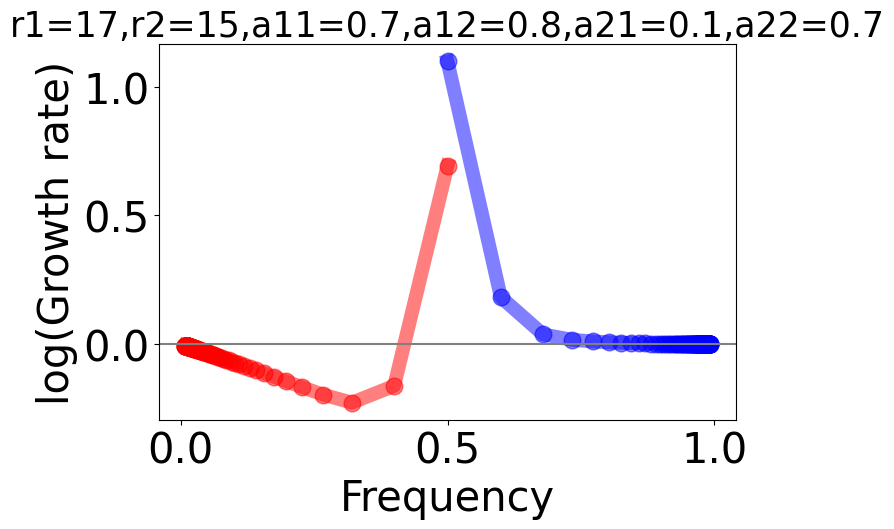

In [15]:
# Same result:
growth1 = np.log(y1[1:-1])-np.log(y1[0:-2])
growth2 = np.log(y2[1:-1])-np.log(y2[0:-2])

fig, (ax) = plt.subplots(1,figsize=(8, 6))
ax.plot(y_rel1[:-2], growth1, alpha=0.5,marker="o", linewidth=10, markersize=12, color="r")
ax.plot(y_rel2[:-2], growth2, alpha=0.5,marker="o", linewidth=10, markersize=12, color="b")
ax.set(xlabel='Frequency', ylabel='log(Growth rate)')
ax.axhline(y=0, color='grey', linestyle='-')
plt.rcParams.update({'font.size': 30})
ax.set_title('r1='+str(r1)+',r2='+str(r2)+',a11='+str(a11)+',a12='+str(a12)+',a21='+str(a21)+',a22='+str(a22), fontsize=25)
plt.tight_layout()
##plt.savefig('img/yenni_time_series_r1_'+str(r1)+'_r2_'+str(r2)+'_a11_'+str(a11)+'_a12_'+str(a12)+'_a21_'+str(a21)+'_a22_'+str(a22)+'.png', format='png', dpi=50)
plt.show()